In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

In [2]:
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langgraph.prebuilt import create_react_agent

market_research_agent = create_react_agent(llm, 
                                           tools=[YahooFinanceNewsTool()], 
                                           state_modifier='You are a market researcher. Provide fact only, not opinions')

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = market_research_agent.invoke(state)
    
    return Command(
        goto = 'supervisor',
        update = {'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
    )

In [4]:
import yfinance as yf
from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past month"""    
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info

In [5]:
stock_research_tools = [get_stock_price]

stock_research_agent = create_react_agent(
    llm,
    tools=stock_research_tools,
    state_modifier='You are a stock researcher. Provide fact only, not opinions'
)

In [6]:
def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = stock_research_agent.invoke(state)
    print(f'stock_research_node: {result}')
    
    return Command(
        goto = 'supervisor',
        update = {'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
    )

In [7]:
@tool
def company_research_tool(ticker: str) -> dict:
    """Givne a ticker, return the financial information and SEC filings"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_filings = company_info.get_sec_filings()
    
    return {
        'financial_info': financial_info,
        'sec_filings': sec_filings
    }

In [8]:
compay_research_tools = [company_research_tool]

company_research_agent = create_react_agent(llm,
                                            tools=compay_research_tools,
                                            state_modifier='You are a company researcher. Provide facts only, not opinions')

In [9]:
def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = company_research_agent.invoke(state)
    
    return Command(
        goto = 'supervisor',
        update = {'messages': [HumanMessage(content=result['messages'][-1].content, name='company_research')]},
    )
    

In [16]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information,
    Please decide whether to buy, sell, or hold the stock.
    Information: {messages}
    """
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    result = analyst_chain.invoke({'messages': state['messages'][1:]})
    
    return {'messages': [result]}

In [11]:
from typing import Literal
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END
from langgraph.types import Command

members = ["market_research", "stock_research", "company_research"]

options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""    
    next: Literal[*options]
    

In [12]:
def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    
    if goto == "FINISH":
        goto = "analyst"
        
    return Command(goto=goto)

In [ ]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("analyst", analyst_node)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)

graph = graph_builder.compile()


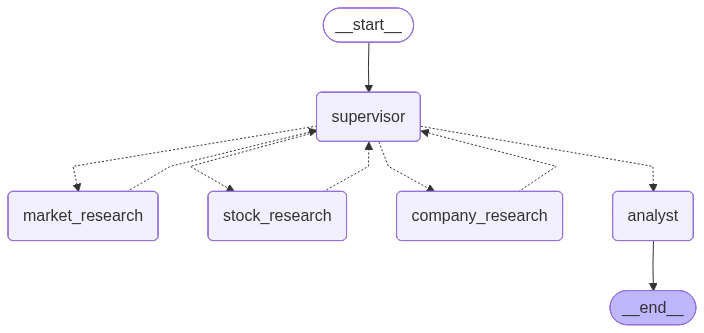

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
for chunk in graph.stream(
    {"messages": [("user", "Whould you invest in Snowflake?")]}, stream_mode="values"
): chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Whould you invest in Snowflake?
================================ Human Message =================================
Name: market_research

Here are some recent updates on Snowflake Inc. (NYSE:SNOW):

1. **Scotiabank**: The firm raised its price target for Snowflake to $290 from $280, maintaining an "Outperform" rating. The firm highlighted strong FQ3 2026 product revenue.

2. **Raymond James**: Assumed coverage with an "Outperform" rating and a price objective of $250, down from a prior target of $274. Analyst Adam Tindle mentioned the company is at an inflection point.

3. **TD Cowen**: Reiterated a "Buy" rating with a $134 price target.

4. **Insider Activity**: There was a significant sale of shares by insiders amounting to US$8.2 million, suggesting some hesitancy.

5. **Bernstein**: Boosted its price target to $237 from $221, maintaining a Market Perform rating. This came after the company increased its

/var/folders/5q/h0j_qc4x00x4kwkjdh13l3q80000gn/T/ipykernel_16153/3226091759.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_info = yf.download(ticker, period='1mo').to_dict()
[*********************100%***********************]  1 of 1 completed


stock_research_node: {'messages': [HumanMessage(content='Whould you invest in Snowflake?', additional_kwargs={}, response_metadata={}, id='d7700896-ca93-422c-8b76-84f0639ecef7'), HumanMessage(content='Here are some recent updates on Snowflake Inc. (NYSE:SNOW):\n\n1. **Scotiabank**: The firm raised its price target for Snowflake to $290 from $280, maintaining an "Outperform" rating. The firm highlighted strong FQ3 2026 product revenue.\n\n2. **Raymond James**: Assumed coverage with an "Outperform" rating and a price objective of $250, down from a prior target of $274. Analyst Adam Tindle mentioned the company is at an inflection point.\n\n3. **TD Cowen**: Reiterated a "Buy" rating with a $134 price target.\n\n4. **Insider Activity**: There was a significant sale of shares by insiders amounting to US$8.2 million, suggesting some hesitancy.\n\n5. **Bernstein**: Boosted its price target to $237 from $221, maintaining a Market Perform rating. This came after the company increased its fiscal